In [44]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('emotion-recognition-zero2gans-project')
jovian.set_colab_id('19x8FHPb7GAPd0KwMf8OIin-Az-cWcX5u')

# Facial Expression Recognition FER2013
In this project we will build a Convolutional Neural Network model on the FER2013 dataset. This dataset is taken from a [Kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview) which conducted 8 years ago. By analysing the dataset, we can make the following conclusions:
- Each image in the data in a 48 x 48 x 3 image
- It is a classification problem where we will classify the emotions expressed by the individual subjects.


In [45]:
!pip install jovian --upgrade --quiet

In [46]:
!pip install opendatasets --upgrade --quiet

In [47]:
import opendatasets as od

In [48]:
od.download('https://www.kaggle.com/msambare/fer2013')

Skipping, found downloaded files in "./fer2013" (use force=True to force download)


## Importing the required libraries

In [49]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
project_name = 'emotion-recognition'

In [51]:
data_dir = './fer2013'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['angry', 'neutral', 'surprise', 'fear', 'happy', 'disgust', 'sad']


We can see that our data has already been segregated to train and test folders. Within the train folder we can see that there are 7 different classes to classify the expressions.

We will use ImageFolder and ToTensor to create our dataset

In [52]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [53]:
dataset = ImageFolder('./fer2013/train', transform=ToTensor())
test_dataset = ImageFolder('./fer2013/test', transform=ToTensor())

## Exploring the FER2013 dataset

In [54]:
print("No of training examples:", len(dataset))
print("No of test examples:", len(test_dataset))

No of training examples: 28709
No of test examples: 7178


In [55]:
classes = dataset.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [56]:
num_classes = len(classes)
print("No of classes:", num_classes)

No of classes: 7


In [57]:
img, label = dataset[0]
img_shape = img.shape
print("Shape of each image in dataset:", img_shape)

Shape of each image in dataset: torch.Size([3, 48, 48])


In [58]:
count = np.zeros(10)

for _,label in dataset:
  count[label] = count[label]+1

count_dict = dict(zip(dataset.classes, list(count)))
print("No of images in each class:")
count_dict

No of images in each class:


{'angry': 3995.0,
 'disgust': 436.0,
 'fear': 4097.0,
 'happy': 7215.0,
 'neutral': 4965.0,
 'sad': 4830.0,
 'surprise': 3171.0}

In [59]:
def show_example(dataset, index):
  img, label = dataset[index]
  print("Label (numeric):", label)
  print("Label (textual):", classes[label])
  print("Image:")
  plt.imshow(img.permute((1,2,0)))


Label (numeric): 0
Label (textual): angry
Image:


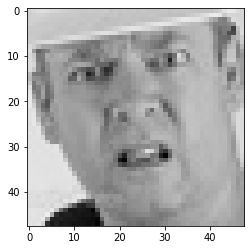

In [60]:
show_example(dataset, 4)

Label (numeric): 2
Label (textual): fear
Image:


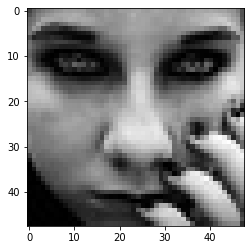

In [61]:
show_example(dataset, 5768)

Label (numeric): 6
Label (textual): surprise
Image:


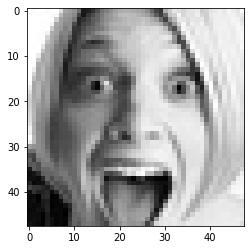

In [62]:
show_example(dataset, 27000)

In [63]:
# Saving the work
# jovian.commit(project=project_name, environment=None)

## Preparing data for training
Creating test and validation sets using shuffled data via random_split. We will also create data loaders

In [64]:
batch_size = 128

In [65]:
dataset_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Here I have defined a helper function to calculate the mean and standard deviation of the training data in each colour channel. This will then be used to normalise the data. Normalising the training data will not only improve the speed of training but will also prevent overfitting

In [66]:
def get_mean_std(loader):
  channels_sum, channels_sq_sum, num_batches = 0, 0, 0

  for data,_ in loader:
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_sq_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1

  mean = channels_sum/num_batches
  std = (channels_sq_sum/num_batches - mean**2)**0.5

  return mean, std

In [67]:
stats = get_mean_std(dataset_loader)
stats

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(tensor([0.5077, 0.5077, 0.5077]), tensor([0.2551, 0.2551, 0.2551]))

In the following cell, the data is normalised and random transforms are applied to the data. The transforms will force the model to learn features corresponding to our objective and will inturn prevent overfitting.

In [68]:
dataset_tfms = tt.Compose([tt.RandomCrop(48, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotation(15),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [69]:
dataset = ImageFolder('./fer2013/train', dataset_tfms)
test_dataset = ImageFolder('./fer2013/test', test_tfms)

We will use majority of the data for training and a small portion of it for validation. As the dataset is currently sorted, we will implement the random_split() function to separate the data into the training and validation sets. This will make sure that the 2 sets are from the same distribution.

In [70]:
torch.manual_seed(50)
val_size = 3709
train_size = len(dataset) - val_size

In [71]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(25000, 3709)

In [72]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualising the training data by making a grid of pictures in a batch:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate fr

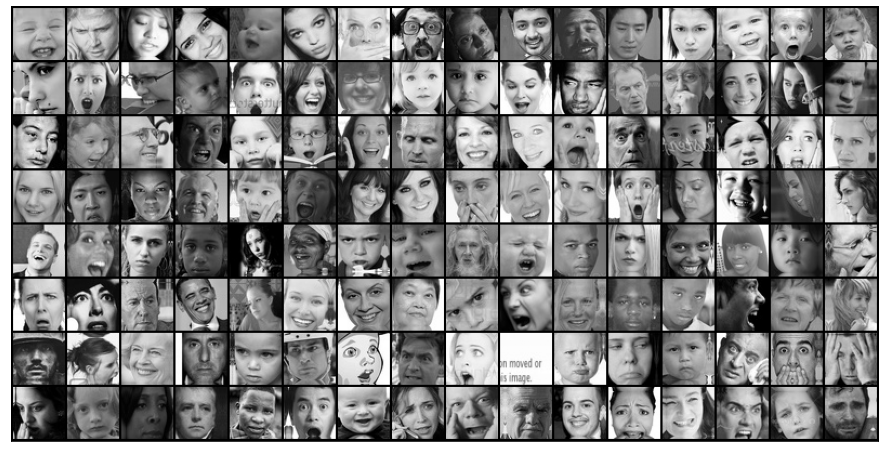

In [73]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:batch_size], nrow=16).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader);

## Moving data loaders to the GPU
We intend to make use of the GPU's capability of multithreading. Moving our data and model to the GPU will help training the model at a high speed. To do so we're defining some useful helper functions to mode the data to the GPU if it is currently on the CPU.




In [74]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [75]:
device = get_default_device()
device

device(type='cuda')

In [76]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Defining Base Model Class
The ImageClassificationBase Class is defined in this segment of the code. Our FER2013 model will soon be derived from this base class. Along with the base class, some helper functions to evaluate the model and plot losses and accuracies are also defined.

In [77]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)                       # Generate predictions
    loss = F.cross_entropy(out,labels)        # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                       # Generate predictions
    loss = F.cross_entropy(out, labels)      # Calculate loss
    acc = accuracy(out, labels)              # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     # Combining losses
    batch_acc = [x['val_acc'] for x in outputs]       
    epoch_acc = torch.stack(batch_acc).mean()         # Combining accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch[{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [78]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader, test=False):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

Some helper functions to plot graphs for analysis:

In [79]:
def plot_acc_loss(history):
    accuracies = [x['val_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history]
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(accuracies, '-x')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].set_title('Accuracy vs No. of epochs');

    ax[1].plot(train_losses, '-bx')
    ax[1].plot(val_losses, '-rx')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['Training', 'Validation'])
    ax[1].set_title('Loss vs. No. of epochs');

The fit function is defined up ahead. The function makes use of a learning rate scheduler to alter learning rate according to the number of epochs. This will help us fit the model to the data in a better.

In [80]:
def fit(epochs, max_lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache
    history = []
    optimizer = opt_func(model.parameters(), max_lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

## Defining FER2013Model Class

In [81]:
def conv_block(input_channels, output_channels, pool=False, tanh=False):
  layers = [
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
  ]

  if tanh:
    layers[-1] = nn.Tanh(inplace=True)
    
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

I am defining the FER2013 Model ahead. I have implemented an architecture similar to that of ResNet9 but am using 3 residual layers

In [82]:
class FER2013Model(ImageClassificationBase):
    def __init__(self, input_channels, output_channels):
        super().__init__()
                                                        #input 3 x 48 x 48
        self.conv1 = conv_block(input_channels, 32)     # 32 x 48 x 48
        self.conv2 = conv_block( 32, 64, pool=True)     # 64 x 24 x 24
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
                                                        # 128 x 24 x 24
        self.conv3 = conv_block(64, 128, pool=True)     # 128 x 12 x 12
        self.conv4 = conv_block(128, 256, pool=True)    # 256 x 6 x 6
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv5 = conv_block(256, 512)               # 512 x 6 x 6
        self.conv6 = conv_block(512, 1024, pool=True)   # 1024 x 3 x 3
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024,1024))

        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Dropout(0.4),
                                        nn.Linear(1024, output_channels))
        
    def forward(self, xb):
      out = self.conv1(xb)
      out = self.conv2(out)
      out = self.res1(out) + out
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.res2(out) + out
      out = self.conv5(out)
      out = self.conv6(out)
      out = self.res3(out) + out
      out = self.classifier(out)

      return out

## Training the model
The model is defined providing input channels as 3, and output as a tensor of length 7, representing the 7 expressions. It is then trained with the mentioned hyperparameters

In [83]:
model = to_device(FER2013Model(3, 7), device)
model

FER2013Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)

On evaluating the randomly initialized model, we see that the raw accuracy is around 1/7. This is to be expected as randomly guessing an expression will give us 1/7 probability of getting it right.

In [84]:
evaluate(model, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.08734267204999924, 'val_loss': 3.792773962020874}

In [86]:
num_epochs = 10
opt_func = torch.optim.Adam
max_lr = 1e-3

In [88]:
history = fit(num_epochs, max_lr, model, train_loader, val_loader, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0], train_loss: 1.7251, val_loss: 1.7026, val_acc: 0.4037
Epoch[1], train_loss: 1.5329, val_loss: 1.4580, val_acc: 0.4748
Epoch[2], train_loss: 1.4053, val_loss: 1.4740, val_acc: 0.4882
Epoch[3], train_loss: 1.2761, val_loss: 1.2505, val_acc: 0.5430
Epoch[4], train_loss: 1.1588, val_loss: 1.1582, val_acc: 0.5716
Epoch[5], train_loss: 1.0724, val_loss: 1.1353, val_acc: 0.5848
Epoch[6], train_loss: 1.0112, val_loss: 1.0540, val_acc: 0.6201
Epoch[7], train_loss: 0.9410, val_loss: 1.0015, val_acc: 0.6245
Epoch[8], train_loss: 0.8849, val_loss: 0.9858, val_acc: 0.6277
Epoch[9], train_loss: 0.8377, val_loss: 0.9717, val_acc: 0.6465


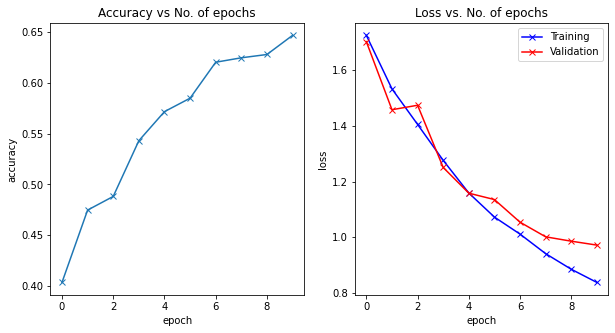

In [89]:
plot_acc_loss(history)

In [90]:
jovian.reset()
jovian.log_hyperparams({
    'arch': 'ResNet',
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': max_lr,
})

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [91]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [92]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/me19b197/emotion-recognition


'https://jovian.ai/me19b197/emotion-recognition'

## Making predictions on few samples in Train/Validation data

In [93]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

Label: fear , Predicted: sad


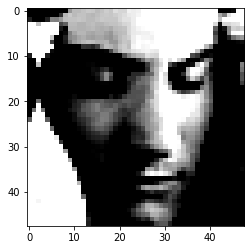

In [94]:
img, label = dataset[5156]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))

Label: happy , Predicted: happy


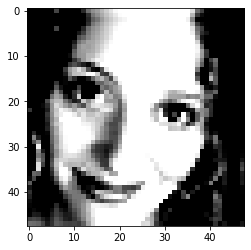

In [95]:
img, label = dataset[9069]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))

Label: angry , Predicted: fear


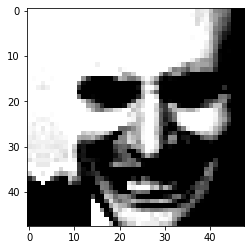

In [96]:
img, label = dataset[1556]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))

In [111]:
print(f"Training accuracy of our model: {evaluate(model, train_loader)['val_acc']*100:4.2f}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training accuracy of our model: 68.61


## Saving and Commiting the work


In [104]:
torch.save(model.state_dict(), 'emotion-recognition.pth')

In [105]:
!pip install jovian --upgrade --quiet

In [106]:
import jovian

In [107]:
jovian.reset()
jovian.log_hyperparams({
    'arch': 'ResNet',
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': max_lr,
})

[jovian] Hyperparams logged.


In [108]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [109]:
jovian.commit(project=project_name, environment=None, outputs=['emotion-recognition.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (emotion-recognition.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/me19b197/emotion-recognition


'https://jovian.ai/me19b197/emotion-recognition'